## Librairies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2 as cv
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.preprocessing import image
from keras.utils import to_categorical
from tensorflow.keras.layers import Input, Lambda ,Dense ,Flatten ,Dropout
import tensorflow as tf
import os
%matplotlib inline

In [2]:
!git clone https://github.com/KhadijaAbdelJalili/ProjetDL.git

Cloning into 'ProjetDL'...
remote: Enumerating objects: 48428, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 48428 (delta 4), reused 11 (delta 2), pack-reused 48415
Receiving objects: 100% (48428/48428), 46.72 MiB | 41.38 MiB/s, done.
Resolving deltas: 100% (1226/1226), done.
Checking out files: 100% (54052/54052), done.


#### Data loading

In [3]:
labels = pd.read_csv("ProjetDL/Labels.csv")
labels = labels.drop(columns="#")
new_labels = [(labels["Class"][item], labels["File_Name"][item]) for item in labels.index]
images = [cv.imread("ProjetDL/images/"+cl+"/"+f) for cl, f in new_labels]

#### Numbers of images

In [4]:
print("numbers of images is ", len(images), labels.shape)

numbers of images is  54049 (54049, 2)


#### Some useful functions

In [5]:
def dico_size(shapes):
    dico = {}
    for shape in shapes:
        if dico.get(shape, False) == False:
            dico[shape] = 1
        else: 
            dico[shape] = dico[shape] + 1
    return dico

#### Visualize images sizes in our dataset

In [6]:
shapes = [img.shape for img in images]
shapes_sorted = sorted(shapes)
dico_size(shapes_sorted)

{(64, 64, 3): 53401, (256, 256, 3): 638, (1024, 768, 3): 10}

#### Resize all images to (64x64x3)

In [7]:
images_resized = []
for img in images:
    if img.shape != (64, 64, 3):
        img = cv.resize(img, (64, 64), interpolation = cv.INTER_AREA)
    images_resized.append(img)

In [8]:
dico_size(sorted([img.shape for img in images_resized]))

{(64, 64, 3): 54049}

In [9]:
data = np.array(images_resized)
print(data.shape)

(54049, 64, 64, 3)


In [10]:
# Import label encoder
from sklearn import preprocessing
  
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
y = labels
# # Encode labels in column 'species'.
y['Class'] = label_encoder.fit_transform(y['Class'])
uniq_labels=y["Class"].unique()
y = y['Class'].to_numpy()
y.shape


(54049,)

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size = 0.2)
X_train = X_train.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print("x_train", X_train.shape, "y_train", y_train.shape, "\nx_test", X_test.shape, "y_test", y_test.shape)

x_train (43239, 64, 64, 3) y_train (43239, 32) 
x_test (10810, 64, 64, 3) y_test (10810, 32)


In [12]:
#Initialising vgg16 
classifier_vgg16 = VGG16(input_shape= (64,64,3),include_top=False,weights='imagenet')

58889256/58889256 [==============================] - 1s 0us/step


In [13]:
#don't train existing weights for vgg16
for layer in classifier_vgg16.layers:
    layer.trainable = False

In [14]:
classifier = classifier_vgg16.output#head mode
classifier = Flatten()(classifier)#adding layer of flatten
classifier = Dense(units=256, activation='relu')(classifier)
classifier = Dropout(0.6)(classifier)
classifier = Dense(units=32, activation='softmax')(classifier)

model = Model(inputs = classifier_vgg16.input , outputs = classifier)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [16]:
history = model.fit(X_train, y_train, epochs=20, batch_size=64,validation_data=(X_test,y_test))

Epoch 1/20
676/676 [==============================] - 35s 39ms/step - loss: 1.7093 - accuracy: 0.4822 - val_loss: 0.7178 - val_accuracy: 0.8361
Epoch 2/20
676/676 [==============================] - 25s 37ms/step - loss: 0.8738 - accuracy: 0.7204 - val_loss: 0.4482 - val_accuracy: 0.8992
Epoch 3/20
676/676 [==============================] - 26s 38ms/step - loss: 0.6433 - accuracy: 0.7976 - val_loss: 0.3168 - val_accuracy: 0.9230
Epoch 4/20
676/676 [==============================] - 25s 38ms/step - loss: 0.5348 - accuracy: 0.8339 - val_loss: 0.2459 - val_accuracy: 0.9398
Epoch 5/20
676/676 [==============================] - 25s 37ms/step - loss: 0.4598 - accuracy: 0.8545 - val_loss: 0.2069 - val_accuracy: 0.9503
Epoch 6/20
676/676 [==============================] - 26s 38ms/step - loss: 0.4131 - accuracy: 0.8692 - val_loss: 0.1936 - val_accuracy: 0.9521
Epoch 7/20
676/676 [==============================] - 25s 38ms/step - loss: 0.3626 - accuracy: 0.8867 - val_loss: 0.1646 - val_accuracy:

In [20]:
score = model.evaluate(x = X_test, y = y_test, verbose = 0)
print('Accuracy for test images:', round(score[1]*100, 3), '%')

Accuracy for test images: 96.91 %


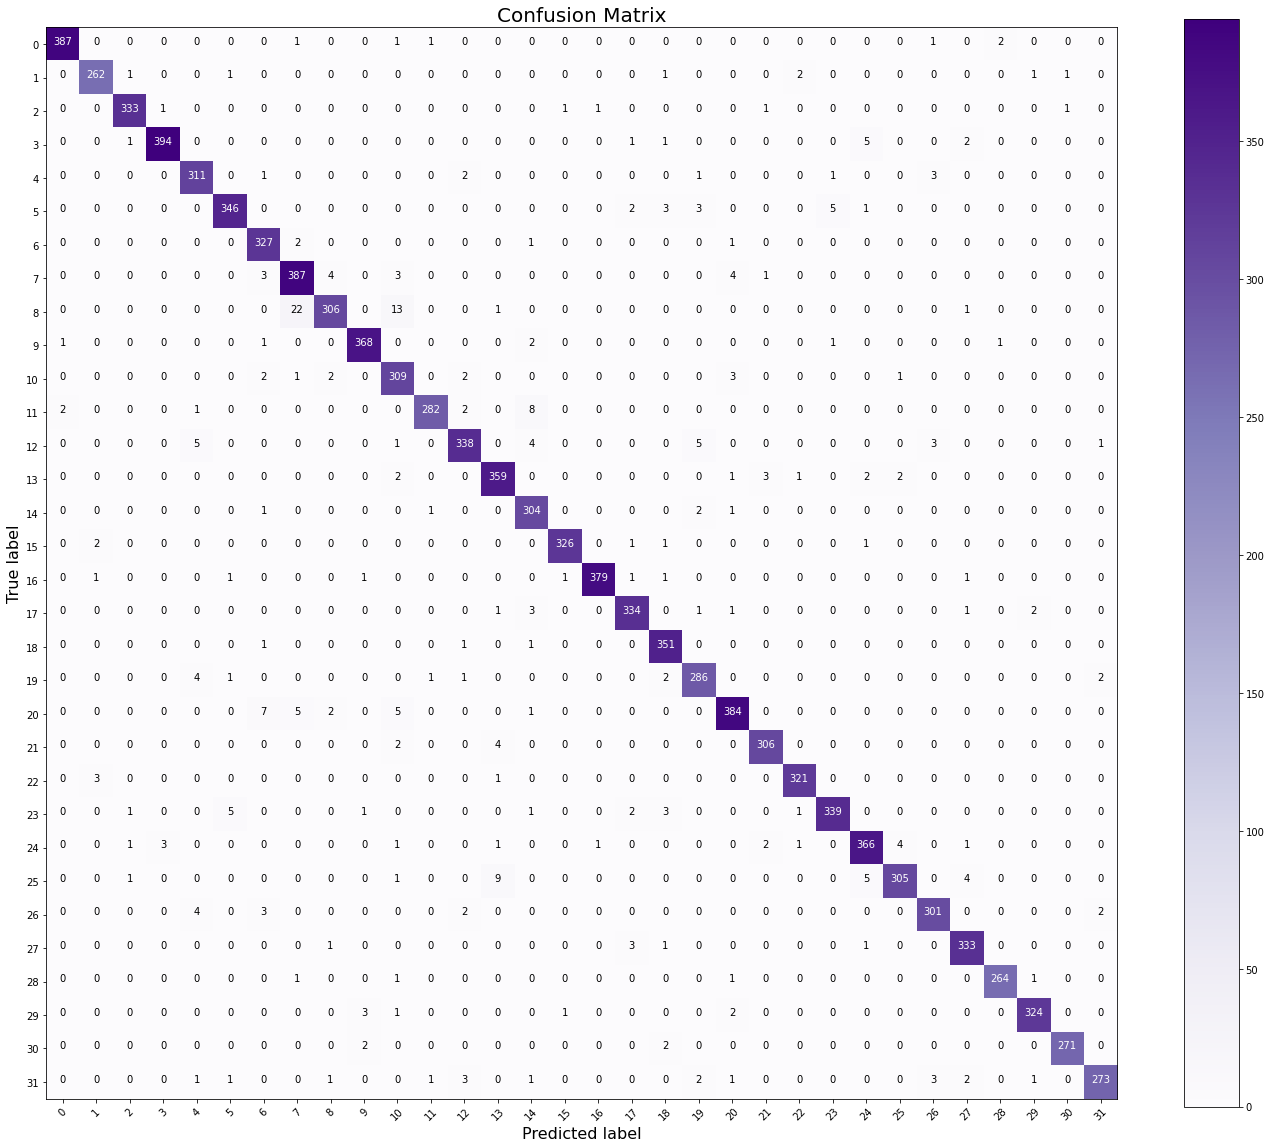

In [22]:
def plot_confusion_matrix(y, y_pred):
    y = np.argmax(y, axis = 1)
    y_pred = np.argmax(y_pred, axis = 1)
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize = (24, 20))
    ax = plt.subplot()
    plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Purples)
    plt.colorbar()
    plt.title("Confusion Matrix")
    
    tick_marks = np.arange(len(uniq_labels))
    plt.xticks(tick_marks, uniq_labels, rotation=45)
    plt.yticks(tick_marks, uniq_labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ax.title.set_fontsize(20)
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_fontsize(16)
    limit = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment = "center",color = "white" if cm[i, j] > limit else "black")
    plt.show()

from sklearn.metrics import confusion_matrix
import itertools

y_test_pred = model.predict(X_test, batch_size = 64, verbose = 0)
plot_confusion_matrix(y_test, y_test_pred)

#### VGG16 accuracy and loss plot

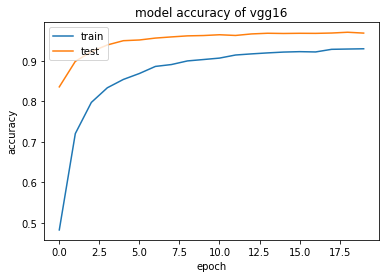

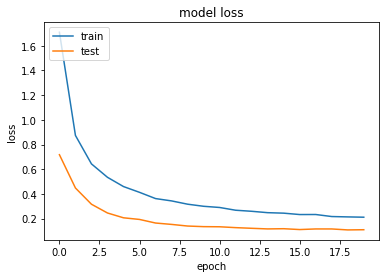

In [19]:
#vgg16
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy of vgg16')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()